<a href="https://colab.research.google.com/github/ubermenchh/learnpytorch/blob/main/vit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

[INFO] torch/torchvision versions not as required, installing nightly versions.
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113
torch version: 2.0.1+cu118
torchvision version: 0.15.2+cu118


In [2]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 3881, done.
remote: Counting objects: 100% (3881/3881), done.
remote: Compressing objects: 100% (1601/1601), done.
remote: Total 3881 (delta 2275), reused 3757 (delta 2219), pack-reused 0
Receiving objects: 100% (3881/3881), 647.77 MiB | 21.63 MiB/s, done.
Resolving deltas: 100% (2275/2275), done.
Updating files: 100% (248/248), done.


In [3]:
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

In [4]:
train_dir = image_path / 'train'
test_dir = image_path / 'test'

In [5]:
IMG_SIZE = 224

manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

manual_transforms

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)

In [6]:
BATCH_SIZE = 32

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir, test_dir=test_dir, transform=manual_transforms, batch_size=BATCH_SIZE)

len(train_dataloader), len(test_dataloader), class_names

(8, 3, ['pizza', 'steak', 'sushi'])

In [7]:
image_batch, label_batch = next(iter(train_dataloader))
img, label = image_batch[0], label_batch[0]

img.shape, label

(torch.Size([3, 224, 224]), tensor(2))

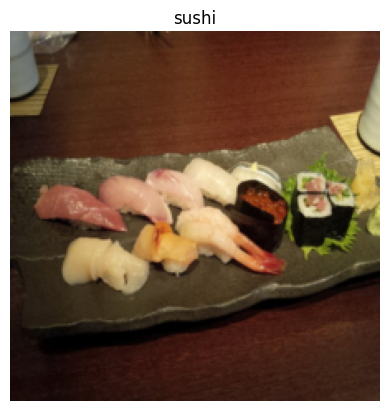

In [8]:
plt.imshow(img.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis('off');

In [9]:
import math

In [10]:
math.pi

3.141592653589793

In [11]:
type(torch.pi)

float

In [12]:
import numpy as np

In [13]:
def gelu(x):
    x = torch.tensor(x)
    return 0.5 * x * (1 + np.tanh(np.sqrt(2 / np.pi) * (x + 0.044715 * x**3)))

In [14]:
x = np.linspace(-3, 3, 1000)

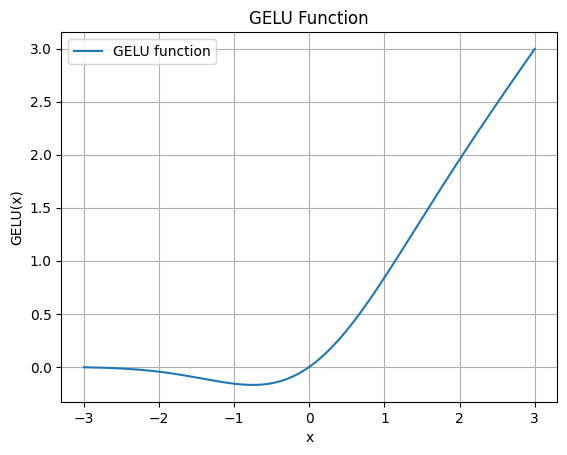

In [15]:
plt.plot(x, gelu(x), label="GELU function")
plt.xlabel('x')
plt.ylabel('GELU(x)')
plt.title('GELU Function')
plt.legend()
plt.grid(True)
plt.show()

\begin{aligned}
\mathbf{z}_0 & =\left[\mathbf{x}_{\text {class }} ; \mathbf{x}_p^1 \mathbf{E} ; \mathbf{x}_p^2 \mathbf{E} ; \cdots ; \mathbf{x}_p^N \mathbf{E}\right]+\mathbf{E}_{\text {pos }}, & & \mathbf{E} \in \mathbb{R}^{\left(P^2 \cdot C\right) \times D}, \mathbf{E}_{p o s} \in \mathbb{R}^{(N+1) \times D} \\
\mathbf{z}_{\ell}^{\prime} & =\operatorname{MSA}\left(\operatorname{LN}\left(\mathbf{z}_{\ell-1}\right)\right)+\mathbf{z}_{\ell-1}, & & \ell=1 \ldots L \\
\mathbf{z}_{\ell} & =\operatorname{MLP}\left(\operatorname{LN}\left(\mathbf{z}_{\ell}^{\prime}\right)\right)+\mathbf{z}_{\ell}^{\prime}, & & \ell=1 \ldots L \\
\mathbf{y} & =\operatorname{LN}\left(\mathbf{z}_L^0\right) & &
\end{aligned}

In [16]:
height, width, color_channels = 224, 224, 3
patch_size = 16

num_of_patches = int((height * width) / patch_size**2)
num_of_patches

196

In [17]:
embedding_layer_input_shape = (height, width, color_channels)
embedding_layer_output_shape = (num_of_patches, patch_size**2 * color_channels)

In [18]:
embedding_layer_input_shape, embedding_layer_output_shape

((224, 224, 3), (196, 768))

(-0.5, 223.5, 223.5, -0.5)

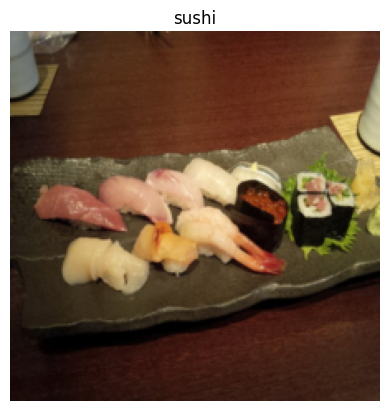

In [19]:
plt.imshow(img.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis('off')

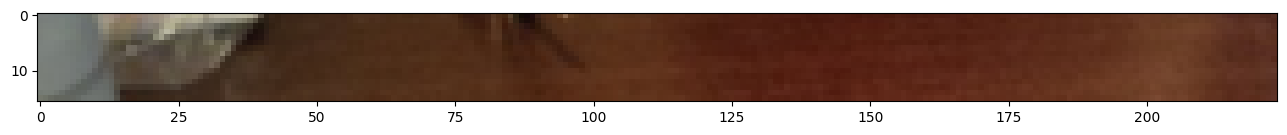

In [20]:
image_permuted = img.permute(1, 2, 0)
patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :]);

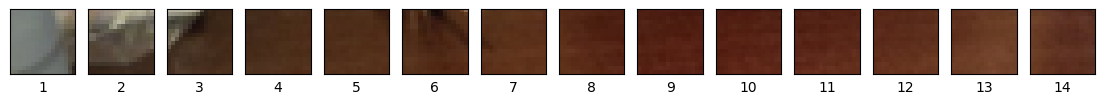

In [21]:
img_size = 224
patch_size = 16
num_of_patches = img_size / patch_size
assert img_size % patch_size == 0, 'Image size must be divisible by patch size'

fig, axs = plt.subplots(nrows=1, ncols=img_size//patch_size, figsize=(num_of_patches, num_of_patches),
                        sharex=True, sharey=True)

for i, patch in enumerate(range(0, img_size, patch_size)):
    axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :]);
    axs[i].set_xlabel(i+1)
    axs[i].set_xticks([])
    axs[i].set_yticks([])

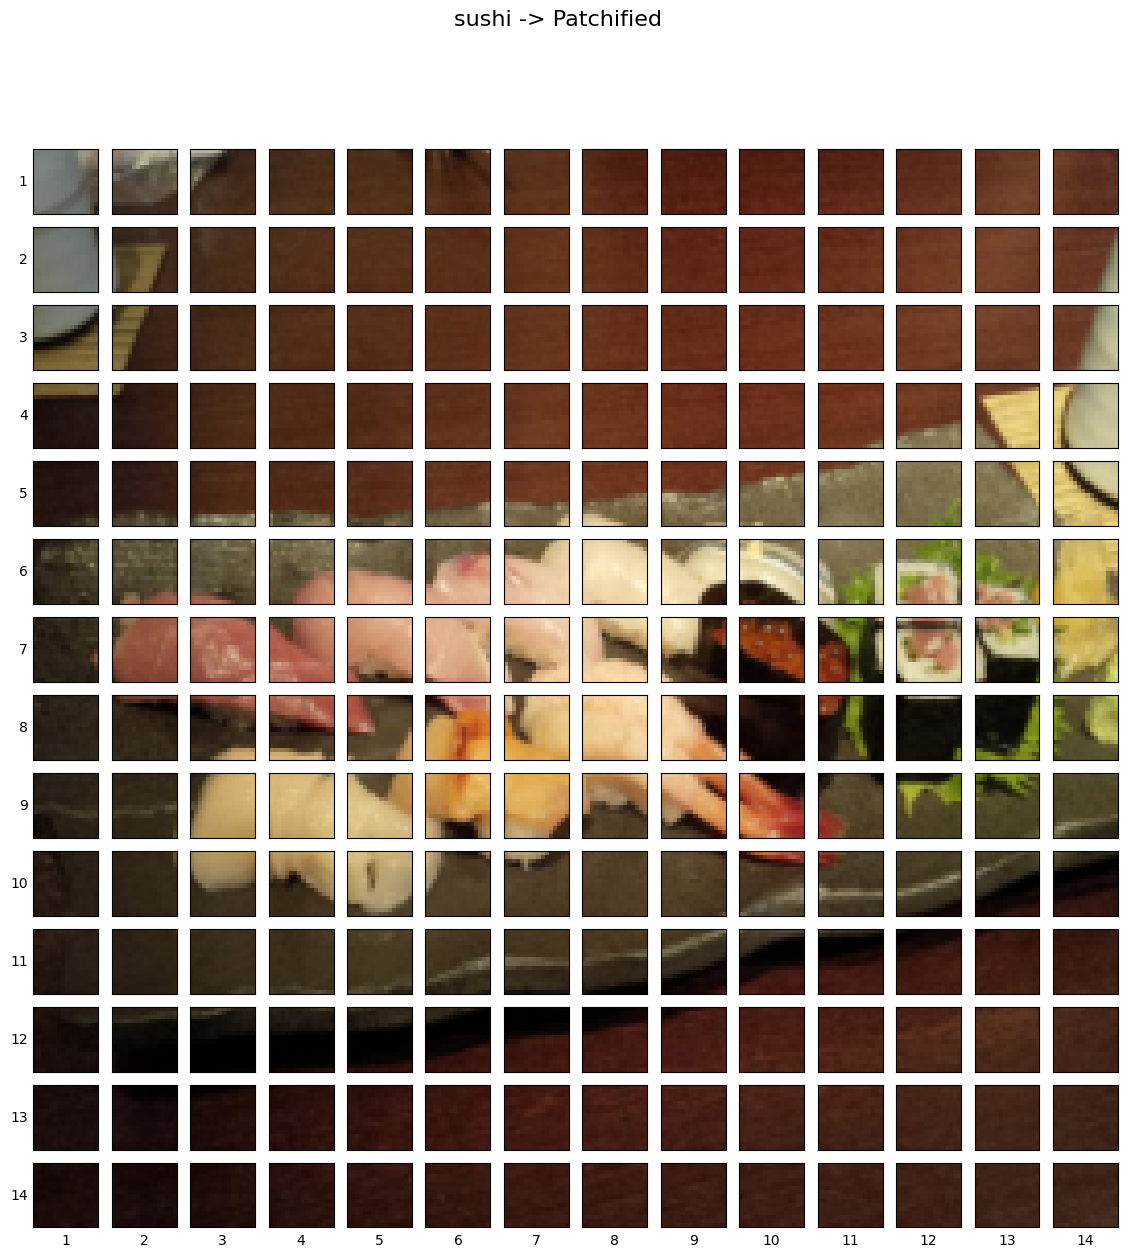

In [22]:
img_size = 224
patch_size = 16
num_patches = img_size / patch_size
assert img_size % patch_size == 0, 'Image size must be divisible by patch size'

fig, axs = plt.subplots(nrows=img_size//patch_size, ncols=img_size//patch_size,
                        figsize=(num_patches, num_patches), sharex=True, sharey=True)

for i, patch_height in enumerate(range(0, img_size, patch_size)):
    for j, patch_width in enumerate(range(0, img_size, patch_size)):
        axs[i, j].imshow(image_permuted[patch_height:patch_height+patch_size, patch_width:patch_width+patch_size, :])
        axs[i, j].set_ylabel(i+1, rotation='horizontal', horizontalalignment='right', verticalalignment='center')
        axs[i, j].set_xlabel(j+1)
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].label_outer()

fig.suptitle(f'{class_names[label]} -> Patchified', fontsize=16)
plt.show()

In [23]:
from torch import nn
patch_size = 16
conv2d = nn.Conv2d(in_channels=3, out_channels=768, kernel_size=patch_size, stride=patch_size, padding=0)

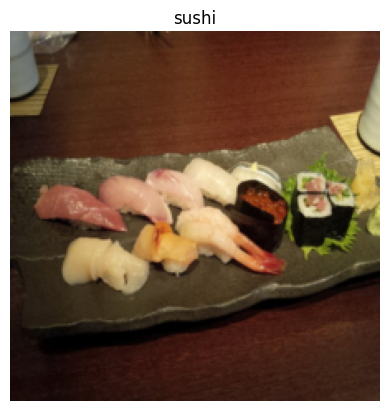

In [24]:
plt.imshow(img.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False);

In [25]:
image_out_of_conv = conv2d(img.unsqueeze(0))
image_out_of_conv.shape

torch.Size([1, 768, 14, 14])

[283, 682, 419, 413, 440]


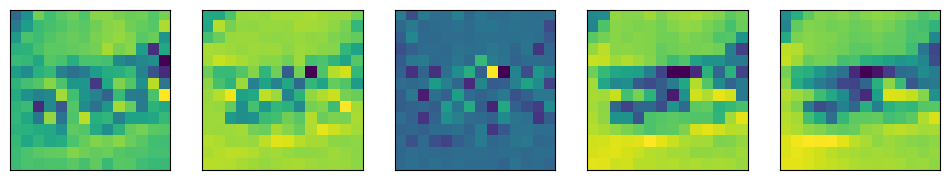

In [26]:
import random
random_indexes = random.sample(range(0, 758), k=5)
print(random_indexes)

fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 12))

for i, idx in enumerate(random_indexes):
    image_conv_feature_map = image_out_of_conv[:, idx, :, :]
    axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
    axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[]);

In [27]:
single_feature_map = image_out_of_conv[:, 0, :, :]
single_feature_map, single_feature_map.requires_grad

(tensor([[[-0.3486, -0.4309, -0.1007, -0.1983, -0.2032, -0.1532, -0.2370,
           -0.1978, -0.1867, -0.1948, -0.2184, -0.2403, -0.2871, -0.2326],
          [-0.3325, -0.2145, -0.2031, -0.2194, -0.2172, -0.2253, -0.2552,
           -0.2380, -0.2285, -0.2385, -0.2661, -0.2997, -0.3095, -0.2656],
          [-0.3626, -0.2184, -0.1865, -0.2135, -0.2187, -0.2371, -0.2576,
           -0.2549, -0.2475, -0.2575, -0.2887, -0.3117, -0.2933, -0.4330],
          [-0.2148, -0.1071, -0.1969, -0.2024, -0.2292, -0.2435, -0.2807,
           -0.2635, -0.2659, -0.2623, -0.2847, -0.2730, -0.5616, -0.5609],
          [-0.0785, -0.1303, -0.2251, -0.1620, -0.2157, -0.2619, -0.2674,
           -0.2637, -0.2511, -0.3699, -0.4119, -0.3706, -0.4290, -0.4844],
          [-0.2099, -0.2253, -0.3313, -0.4434, -0.4079, -0.3773, -0.5792,
           -0.6853, -0.5587, -0.6779, -0.4759, -0.3800, -0.3638, -0.5222],
          [-0.1544, -0.4376, -0.4715, -0.4843, -0.6609, -0.6165, -0.7316,
           -0.5045, -0.2493, -0.

In [28]:
flatten = nn.Flatten(start_dim=2, end_dim=3)

original image shape: torch.Size([3, 224, 224])
image feature map shape: torch.Size([1, 768, 14, 14])
flattened image feature map shape: torch.Size([1, 768, 196])


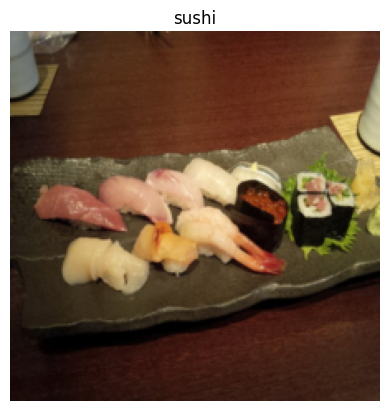

In [29]:
plt.imshow(img.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False);
print(f'original image shape: {img.shape}')

image_out_of_conv = conv2d(img.unsqueeze(0))
print(f'image feature map shape: {image_out_of_conv.shape}')

image_out_of_conv_flattened = flatten(image_out_of_conv)
print(f'flattened image feature map shape: {image_out_of_conv_flattened.shape}')

In [30]:
image_out_of_conv_flattened_reshaped = image_out_of_conv_flattened.permute(0, 2, 1)
print(f'patch embedding sequence shape: {image_out_of_conv_flattened_reshaped.shape}')

patch embedding sequence shape: torch.Size([1, 196, 768])


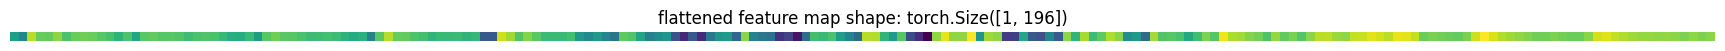

In [31]:
single_flattened_feature_map = image_out_of_conv_flattened_reshaped[:, :, 0]

plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f'flattened feature map shape: {single_flattened_feature_map.shape}')
plt.axis(False);

In [32]:
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels=3, patch_size=16, embedding_dim=768):
        super().__init__()
        self.patcher = nn.Conv2d(in_channels=in_channels, out_channels=embedding_dim, kernel_size=patch_size, stride=patch_size, padding=0)
        self.flatten = nn.Flatten(start_dim=2, end_dim=3)

    def forward(self, x):
        image_resolution = x.shape[-1]
        assert image_resolution % patch_size == 0, 'Input image size must be divisible by patch size'

        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)
        return x_flattened.permute(0, 2, 1)

In [33]:
patchify = PatchEmbedding(in_channels=3, patch_size=16, embedding_dim=768)

print(f'input image shape: {img.unsqueeze(0).shape}')
patch_embedded_image = patchify(img.unsqueeze(0))
print(f'output patch embedding shape: {patch_embedded_image.shape}')

input image shape: torch.Size([1, 3, 224, 224])
output patch embedding shape: torch.Size([1, 196, 768])


In [34]:
random_input_image = (1, 3, 224, 224)
random_input_image_error = (1, 3, 250, 250)

In [35]:
summary(PatchEmbedding(), input_size=random_input_image, col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20, row_settings=['var_names'])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
PatchEmbedding (PatchEmbedding)          [1, 3, 224, 224]     [1, 196, 768]        --                   True
├─Conv2d (patcher)                       [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
├─Flatten (flatten)                      [1, 768, 14, 14]     [1, 768, 196]        --                   --
Total params: 590,592
Trainable params: 590,592
Non-trainable params: 0
Total mult-adds (M): 115.76
Input size (MB): 0.60
Forward/backward pass size (MB): 1.20
Params size (MB): 2.36
Estimated Total Size (MB): 4.17

In [36]:
patch_embedded_image, patch_embedded_image.shape

(tensor([[[-0.1505, -0.1860, -0.3134,  ...,  0.2118,  0.2840,  0.2772],
          [-0.1231, -0.1596, -0.2115,  ...,  0.2016,  0.0931,  0.2350],
          [ 0.0288, -0.1277, -0.2072,  ...,  0.1629,  0.1594,  0.2108],
          ...,
          [-0.0174, -0.0685, -0.1333,  ...,  0.0363,  0.1264,  0.0902],
          [-0.0269, -0.0744, -0.1302,  ...,  0.0532,  0.1307,  0.0955],
          [-0.0360, -0.0865, -0.1399,  ...,  0.0611,  0.1446,  0.1112]]],
        grad_fn=<PermuteBackward0>),
 torch.Size([1, 196, 768]))

In [37]:
batch_size = patch_embedded_image.shape[0]
embedding_dim = patch_embedded_image.shape[-1]

class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dim), requires_grad=True)

print(class_token[:, :, :10])
print(class_token.shape)

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
torch.Size([1, 1, 768])


In [38]:
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image), dim=1)

print(patch_embedded_image_with_class_embedding)
print(patch_embedded_image_with_class_embedding.shape)

tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.1505, -0.1860, -0.3134,  ...,  0.2118,  0.2840,  0.2772],
         [-0.1231, -0.1596, -0.2115,  ...,  0.2016,  0.0931,  0.2350],
         ...,
         [-0.0174, -0.0685, -0.1333,  ...,  0.0363,  0.1264,  0.0902],
         [-0.0269, -0.0744, -0.1302,  ...,  0.0532,  0.1307,  0.0955],
         [-0.0360, -0.0865, -0.1399,  ...,  0.0611,  0.1446,  0.1112]]],
       grad_fn=<CatBackward0>)
torch.Size([1, 197, 768])


In [39]:
num_of_patches = int((height * width) / patch_size**2)

embedding_dim = patch_embedded_image_with_class_embedding.shape[2]

position_embedding = nn.Parameter(torch.ones(1, num_of_patches+1, embedding_dim), requires_grad=True)

print(position_embedding[:, :10, :10])
print(position_embedding.shape)

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
torch.Size([1, 197, 768])


In [40]:
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
print(patch_and_position_embedding)
print(patch_and_position_embedding.shape)

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.8495, 0.8140, 0.6866,  ..., 1.2118, 1.2840, 1.2772],
         [0.8769, 0.8404, 0.7885,  ..., 1.2016, 1.0931, 1.2350],
         ...,
         [0.9826, 0.9315, 0.8667,  ..., 1.0363, 1.1264, 1.0902],
         [0.9731, 0.9256, 0.8698,  ..., 1.0532, 1.1307, 1.0955],
         [0.9640, 0.9135, 0.8601,  ..., 1.0611, 1.1446, 1.1112]]],
       grad_fn=<AddBackward0>)
torch.Size([1, 197, 768])


In [41]:
patch_size = 16

print(f'image tensor shape --> {img.shape}')
height, width = img.shape[1], img.shape[2]

x = img.unsqueeze(0)
print(f'input image with batch dim shape --> {x.shape}')

patch_embedding_layer = PatchEmbedding(in_channels=3, patch_size=patch_size, embedding_dim=768)

patch_embedding = patch_embedding_layer(x)
print(f'patching embedding shape --> {patch_embedding.shape}')

batch_size = patch_embedding.shape[0]
embedding_dim = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dim), requires_grad=True)
print(f'class token embedding shape --> {class_token.shape}')

patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f'patch embedding with class token shape --> {patch_embedding_class_token.shape}')

num_of_patches = int((height * width) / patch_size**2)
position_embed = nn.Parameter(torch.ones(1, num_of_patches+1, embedding_dim), requires_grad=True)

patch_and_position_embed = patch_embedding_class_token + position_embed
print(f'patch and position embedding shape --> {patch_and_position_embed.shape}')

image tensor shape --> torch.Size([3, 224, 224])
input image with batch dim shape --> torch.Size([1, 3, 224, 224])
patching embedding shape --> torch.Size([1, 196, 768])
class token embedding shape --> torch.Size([1, 1, 768])
patch embedding with class token shape --> torch.Size([1, 197, 768])
patch and position embedding shape --> torch.Size([1, 197, 768])


In [42]:
class MultiheadSelfAttentionBlock(nn.Module):
    def __init__(self, embedding_dim=768, num_heads=12, attn_dropout=0):
        super().__init__()
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim, num_heads=num_heads, dropout=attn_dropout, batch_first=True)

    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(query=x, key=x, value=x, need_weights=False)
        return attn_output

In [43]:
multihead_self_attention_block = MultiheadSelfAttentionBlock(embedding_dim=768, num_heads=12)

patched_image_through_msa_block = multihead_self_attention_block(patch_and_position_embedding)
print(f'input shape of MSA block --> {patch_and_position_embedding.shape}')
print(f'output shape of MSA block --> {patched_image_through_msa_block.shape}')

input shape of MSA block --> torch.Size([1, 197, 768])
output shape of MSA block --> torch.Size([1, 197, 768])


In [44]:
class MLPBlock(nn.Module):
    def __init__(self, embedding_dim=768, mlp_size=3072, dropout=0.1):
        super().__init__()

        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim, out_features=mlp_size),
            nn.GELU(),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size, out_features=embedding_dim),
            nn.Dropout(p=dropout)
        )

    def forward(self, x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x

In [45]:
mlp_block = MLPBlock(embedding_dim=768, mlp_size=3072, dropout=0.1)

patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)
print(f'input shape of MLP block --> {patched_image_through_mlp_block.shape}')
print(f'output shape of MLP block --> {patched_image_through_mlp_block.shape}')

input shape of MLP block --> torch.Size([1, 197, 768])
output shape of MLP block --> torch.Size([1, 197, 768])


In [46]:
class TransformerEncoderBlock(nn.Module):
    def __init__(self, embedding_dim=768, num_heads=12, mlp_size=3072, mlp_dropout=0.1, attn_dropout=0):
        super().__init__()
        self.msa_block = MultiheadSelfAttentionBlock(embedding_dim=embedding_dim, num_heads=num_heads, attn_dropout=attn_dropout)
        self.mlp_block = MLPBlock(embedding_dim=embedding_dim, mlp_size=mlp_size, dropout=mlp_dropout)

    def forward(self, x):
        x = self.msa_block(x) + x
        x = self.mlp_block(x) + x
        return x

In [47]:
transformer_encoder_block = TransformerEncoderBlock()

summary(model=transformer_encoder_block, input_size=(1, 197, 768), col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20, row_settings=['var_names'])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiheadSelfAttentionBlock (msa_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

In [48]:
torch_transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=768, nhead=12, dim_feedforward=3072,
                                                             dropout=0.1, activation='gelu', batch_first=True, norm_first=True)
torch_transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [49]:
summary(model=torch_transformer_encoder_layer, input_size=(1, 197, 768),
        col_names=['input_size', 'output_size', 'num_params', 'trainable'], col_width=20, row_settings=['var_names'])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        [1, 197, 768]        7,087,872            True
Total params: 7,087,872
Trainable params: 7,087,872
Non-trainable params: 0
Total mult-adds (M): 0
Input size (MB): 0.61
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.61

In [53]:
class ViT(nn.Module):
    def __init__(self, img_size=224, in_channels=3, patch_size=16, num_transformer_layers=12,
                 embedding_dim=768, mlp_size=3072, num_heads=12, attn_dropout=0, mlp_dropout=0.1,
                 embedding_dropout=0.1, num_classes=1000):
        super().__init__()
        assert img_size % patch_size == 0, 'Image size must be divisible by patch size'

        self.num_patches = (img_size * img_size) // patch_size**2
        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim), requires_grad=True)
        self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches + 1, embedding_dim), requires_grad=True)
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)
        self.patch_embedding = PatchEmbedding(in_channels=in_channels, patch_size=patch_size, embedding_dim=embedding_dim)
        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim, num_heads=num_heads, mlp_size=mlp_size, mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim, out_features=num_classes)
        )

    def forward(self, x):
        batch_size = x.shape[0]
        class_token = self.class_embedding.expand(batch_size, -1, -1)
        x = self.patch_embedding(x)
        x = torch.cat((class_token, x), dim=1)
        x = self.position_embedding + x
        x = self.embedding_dropout(x)
        x = self.transformer_encoder(x)
        x = self.classifier(x[:, 0])
        return x

In [54]:
batch_size = 32
class_token_embedding_single = nn.Parameter(data=torch.randn(1, 1, 768))
class_token_embedding_expanded = class_token_embedding_single.expand(batch_size, -1, -1)

class_token_embedding_single.shape, class_token_embedding_expanded.shape

(torch.Size([1, 1, 768]), torch.Size([32, 1, 768]))

In [55]:
random_image_tensor = torch.randn(1, 3, 224, 224)
vit = ViT(num_classes=len(class_names))
vit(random_image_tensor)

tensor([[-0.3556, -0.2960, -0.9915]], grad_fn=<AddmmBackward0>)

In [56]:
summary(model=vit, input_size=(32, 3, 224, 224), col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20, row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [32, 3, 224, 224]    [32, 3]              152,064              True
├─PatchEmbedding (patch_embedding)                           [32, 3, 224, 224]    [32, 196, 768]       --                   True
│    └─Conv2d (patcher)                                      [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
│    └─Flatten (flatten)                                     [32, 768, 14, 14]    [32, 768, 196]       --                   --
├─Dropout (embedding_dropout)                                [32, 197, 768]       [32, 197, 768]       --                   --
├─Sequential (transformer_encoder)                           [32, 197, 768]       [32, 197, 768]       --                   True
│    └─TransformerEncoderBlock (0)                           [32, 197, 768]       [32, 197, 768]

In [58]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [59]:
from going_modular.going_modular import engine

optimizer = torch.optim.Adam(params=vit.parameters(), lr=3e-3, betas=(0.9, 0.999), weight_decay=0.3)
loss_fn = torch.nn.CrossEntropyLoss()
results = engine.train(model=vit, train_dataloader=train_dataloader, test_dataloader=test_dataloader,
                       optimizer=optimizer, loss_fn=loss_fn, epochs=10, device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 4.6153 | train_acc: 0.2812 | test_loss: 2.6198 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.6396 | train_acc: 0.2617 | test_loss: 1.1059 | test_acc: 0.5417
Epoch: 3 | train_loss: 1.2984 | train_acc: 0.2930 | test_loss: 1.2645 | test_acc: 0.2604
Epoch: 4 | train_loss: 1.1568 | train_acc: 0.4102 | test_loss: 1.0037 | test_acc: 0.5417
Epoch: 5 | train_loss: 1.1636 | train_acc: 0.2422 | test_loss: 1.2955 | test_acc: 0.1979
Epoch: 6 | train_loss: 1.1435 | train_acc: 0.2852 | test_loss: 1.0047 | test_acc: 0.5417
Epoch: 7 | train_loss: 1.2092 | train_acc: 0.2812 | test_loss: 1.4278 | test_acc: 0.2604
Epoch: 8 | train_loss: 1.2593 | train_acc: 0.2812 | test_loss: 1.1090 | test_acc: 0.2604
Epoch: 9 | train_loss: 1.0993 | train_acc: 0.2969 | test_loss: 1.0106 | test_acc: 0.5417
Epoch: 10 | train_loss: 1.1634 | train_acc: 0.3984 | test_loss: 1.4155 | test_acc: 0.1979


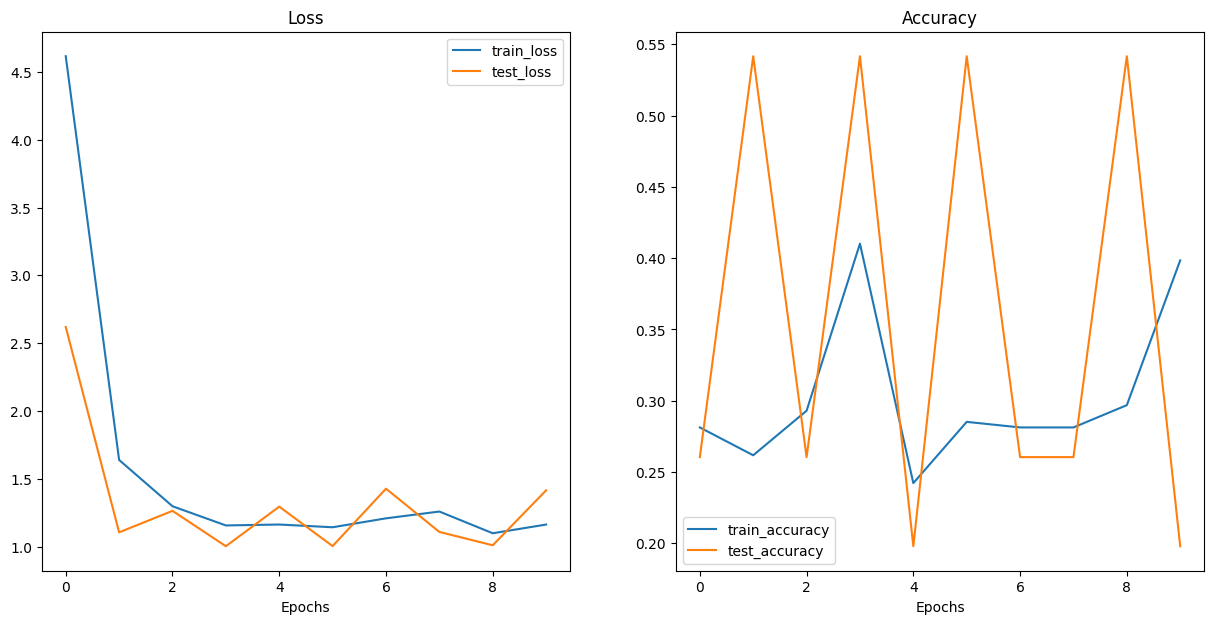

In [60]:
from helper_functions import plot_loss_curves
plot_loss_curves(results)

In [61]:
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False

pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:02<00:00, 164MB/s]


In [62]:
summary(model=pretrained_vit, input_size=(32, 3, 224, 224), col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20, row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 3]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

In [63]:
pretrained_vit_transforms = pretrained_vit_weights.transforms()
pretrained_vit_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [64]:
train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloaders(
    train_dir=train_dir, test_dir=test_dir, transform=pretrained_vit_transforms, batch_size=32
)

In [65]:
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(), lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()
pretrained_vit_results = engine.train(model=pretrained_vit, train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained, optimizer=optimizer,
                                      loss_fn=loss_fn, epochs=10, device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0177 | train_acc: 0.5820 | test_loss: 0.5369 | test_acc: 0.8059
Epoch: 2 | train_loss: 0.3811 | train_acc: 0.9453 | test_loss: 0.3708 | test_acc: 0.8977
Epoch: 3 | train_loss: 0.2368 | train_acc: 0.9570 | test_loss: 0.3068 | test_acc: 0.8778
Epoch: 4 | train_loss: 0.1961 | train_acc: 0.9609 | test_loss: 0.2500 | test_acc: 0.9081
Epoch: 5 | train_loss: 0.1475 | train_acc: 0.9727 | test_loss: 0.2172 | test_acc: 0.8873
Epoch: 6 | train_loss: 0.1310 | train_acc: 0.9727 | test_loss: 0.2092 | test_acc: 0.8873
Epoch: 7 | train_loss: 0.1140 | train_acc: 0.9727 | test_loss: 0.2141 | test_acc: 0.8977
Epoch: 8 | train_loss: 0.1022 | train_acc: 0.9766 | test_loss: 0.2193 | test_acc: 0.8977
Epoch: 9 | train_loss: 0.0920 | train_acc: 0.9766 | test_loss: 0.2149 | test_acc: 0.8977
Epoch: 10 | train_loss: 0.0854 | train_acc: 0.9805 | test_loss: 0.2111 | test_acc: 0.8977


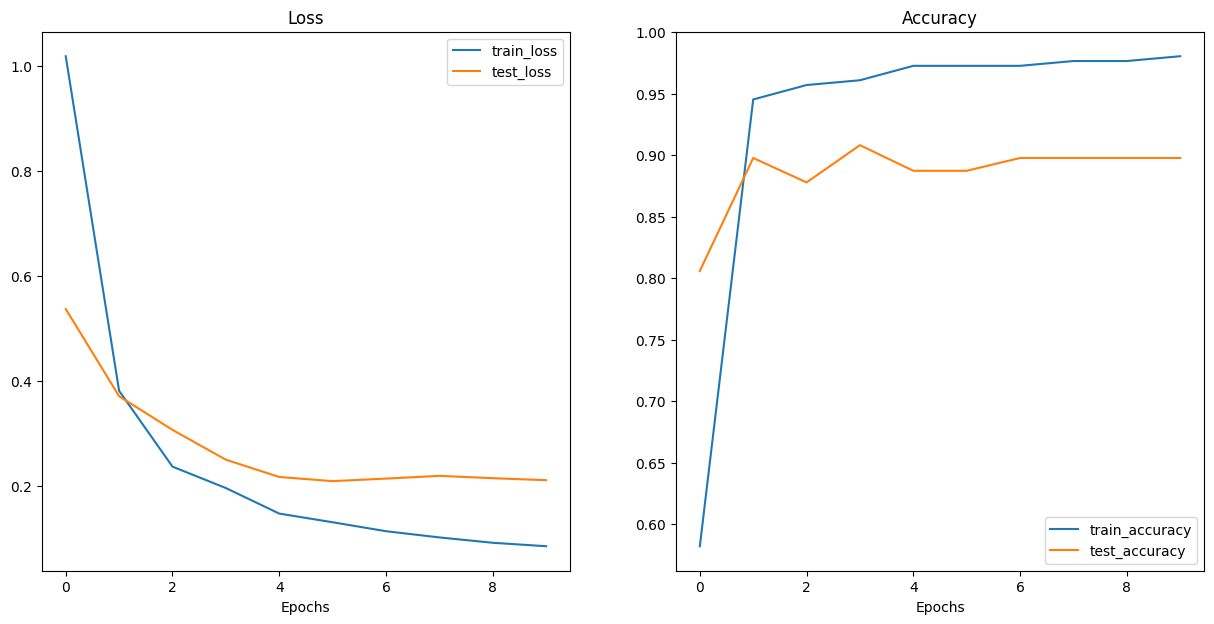

In [66]:
plot_loss_curves(pretrained_vit_results)

In [69]:
from going_modular.going_modular import utils

utils.save_model(model=pretrained_vit, target_dir="models", model_name='pretrained_vit.pth')

[INFO] Saving model to: models/pretrained_vit.pth


In [71]:
from pathlib import Path

pretrained_vit_model_size = Path('models/pretrained_vit.pth').stat().st_size // (1024 * 1024)
pretrained_vit_model_size # in MBs approx

327